# High Value Customer Identification

# Planejamento da Solução

## Input - Entrada

### Problema de Negócio

1. Selecionar os mais valiosos clientes para formar o programa de fidelidade **"INSIDERS"**
2. Conjunto de dados com as vendas de produtos durante 1 ano ( Nov 2015 to Dec 2017 )


## Output - Saída
 
1. A indicação de pessoas para fazer parte do programa de fidelidade **"INSIDERS"**.
2. Relatório com as respostas para as seguintes perguntas:
    - Quem são as pessoas elegíveis para participar do programa de Insiders ?
    - Quantos clientes farão parte do grupo?Quais as principais características desses clientes ?
    - Qual a porcentagem de contribuição do faturamento, vinda do Insiders ?
    - Qual a expectativa de faturamento desse grupo para os próximos meses ?
    - Quais as condições para uma pessoa ser elegível ao Insiders ?
    - Quais as condições para uma pessoa ser removida do Insiders ?
    - Qual a garantia que o programa Insiders é melhor que o restante da base ?
    - Quais ações o time de marketing pode realizar para aumentar o faturamento?

## Tasks - Processo

1. Quem são as pessoas elegíveis para participar do programa de Insiders ?

    - O que é ser elegível ? O que é um cliente "valioso" para a empresa ?
        - Faturamento:
            - Alto Ticket Médio
            - Alto LTV
            - Baixa Recência ou Alta Frequência ( tempo entre as compras ) 
            - Alto Basket Size ( quantidade média de produtos comprados )
            - Baixa probabilidade de Churn
            - Previsão alta de LTV
            - Alta propensão de compra
        #
        - Custo:
            - Baixo número de devoluções
        #
        - Experiência:  
            - Média alta de avaliações

#
2. Quantos clientes farão parte do grupo?

    - Número de clientes
    - % em relação ao total de clientes

#
3. Quais as principais características desses clientes?
    - Escrever os principais atributos dos clientes
        - Idade
        - País
        - Salário
    #
    - Escrever os principais comportamentos de compra dos clientes ( métricas de negócio )
        - Vide acima

#
4. Qual a porcentagem de contribuição do faturamento, vinda do Insiders ?

    - Calcular o faturamento total da empresa durante o ano.
    - Calcular o faturamento (%) apenas do cluster Insiders.

#
5. Qual a expectativa de faturamento desse grupo para os próximos meses ?

    - Cálculo do LTV do grupo Insiders
    - Séries Temporais ( ARMA, ARIMA, HoltWinter, etc )

#
6. Quais as condições para uma pessoa ser elegível ao Insiders ?

    - Qual o período de avaliação ?
    - O "desempenho" do cliente está próximo da média do cluster Insiders.

#
7. Quais as condições para uma pessoa ser removida do Insiders ?

    - O "desempenho" do cliente não está mais próximo da média do cluster Insiders.

#
8. Qual a garantia que o programa Insiders é melhor que o restante da base ?

    - Teste de Hipóteses
    - Teste A/B

#
9. Quais ações o time de marketing pode realizar para aumentar o faturamento?

    - Descontos
    - Preferências de escolha
    - Produtos exclusivos

# 0.0 Imports

In [169]:
import pickle
import warnings
import regex as re
import numpy as np
import pandas as pd
import seaborn as sns

from matplotlib import pyplot as plt
from IPython.display import Image
from matplotlib.gridspec import GridSpec
from plotly import express as px

import umap.umap_ as umap

from sklearn import preprocessing as pp
from sklearn import metrics as m
from sklearn import cluster as c
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer

## 0.1 Helper Functions

In [2]:
def notebook_settings():
    '''Define configurations for notebook, matplotlib and Pandas.'''
    %matplotlib inline
    plt.style.use('bmh')
    plt.rcParams['figure.figsize'] = [22,10]
    plt.rcParams['font.size'] = 24
    plt.rcParams['figure.dpi'] = 100
    
    pd.set_option('display.float_format', lambda x: '%.3f' % x)
    
    # ignore future warnings
    warnings.filterwarnings('ignore')
    
    sns.set()

In [3]:
notebook_settings()

## 0.2 Load Data

In [4]:
data_raw = pd.read_csv('../data/raw/Ecommerce.csv', low_memory=False, encoding='cp1252')

# 1.0 Descrição dos dados

In [5]:
df1 = data_raw.copy()

df1.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Unnamed: 8
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,29-Nov-16,2.550,17850.000,United Kingdom,NaN
1,536365,71053,WHITE METAL LANTERN,6,29-Nov-16,3.390,17850.000,United Kingdom,NaN
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,29-Nov-16,2.750,17850.000,United Kingdom,NaN
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,29-Nov-16,3.390,17850.000,United Kingdom,NaN
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,29-Nov-16,3.390,17850.000,United Kingdom,NaN


## 1.1 Rename Columns

In [6]:
# Drop error column
df1 = df1.drop(columns=['Unnamed: 8'], axis=1)

cols_news = ['invoice_no', 'stock_code', 'description', 'quantity', 'invoice_date',
              'unit_price', 'customer_id', 'country']

df1.columns = cols_news

## 1.2 Data Dimension

In [7]:
print(f'number of rows: {df1.shape[0]}')
print(f'number of cols: {df1.shape[1]}')

number of rows: 541909
number of cols: 8


## 1.3 Data Types

In [8]:
df1.dtypes

invoice_no       object
stock_code       object
description      object
quantity          int64
invoice_date     object
unit_price      float64
customer_id     float64
country          object
dtype: object

## 1.4 Check NA

In [9]:
df1.isna().sum()

invoice_no           0
stock_code           0
description       1454
quantity             0
invoice_date         0
unit_price           0
customer_id     135080
country              0
dtype: int64

## 1.5 Fillout NA

In [10]:
df1.dropna(subset=['description', 'customer_id'], inplace=True)
print(f'impact of drop: {1 - df1.shape[0] / data_raw.shape[0]:.3f}')

impact of drop: 0.249


In [11]:
df1.isna().sum()

invoice_no      0
stock_code      0
description     0
quantity        0
invoice_date    0
unit_price      0
customer_id     0
country         0
dtype: int64

## 1.6 Change Types

In [12]:
# change invoice_date into date
df1['invoice_date'] = pd.to_datetime(df1['invoice_date'], format='%d-%b-%y')

# change customer_id into int 
df1['customer_id'] = df1['customer_id'].astype('int64')

In [13]:
df1.dtypes

invoice_no              object
stock_code              object
description             object
quantity                 int64
invoice_date    datetime64[ns]
unit_price             float64
customer_id              int64
country                 object
dtype: object

## 1.7 Descriptive Statistical

In [14]:
num_attributes = df1.select_dtypes(include=['int64', 'float64'])
cat_attributes = df1.select_dtypes(exclude=['int64', 'float64', 'datetime64[ns]'])

### 1.7.1 Numerical Attributes

In [46]:
# Create metrics of central tendency and dispersion
d1 = pd.DataFrame(num_attributes.apply(lambda x: x.max() - x.min())).rename(columns={0: 'range'}).T
d2 = num_attributes.agg(['min', 'max', 'mean', 'median', 'std', 'skew', 'kurtosis'])

# concat all metrics
m = pd.concat([d1, d2]).T
m = m[['min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']]
m

,min,max,range,mean,median,std,skew,kurtosis
quantity,-80995.000,80995.000,161990.000,12.061,5.000,248.693,0.183,94317.564
unit_price,0.000,38970.000,38970.000,3.460,1.950,69.315,452.219,246924.543
customer_id,12346.000,18287.000,5941.000,15287.691,15152.000,1713.600,0.030,-1.180


- Valores grandes e negativos em quantity (devoluções?)
- Valores negativos em preço unitário (devolução/promoção?)

### 1.7.2 Categorical Attributes

In [71]:
# Count unique itens per columns
count_ = cat_attributes.apply(lambda x: x.unique().shape).T.rename(columns={0:'count'})
count_

,Count
invoice_no,22190
stock_code,3684
description,3896
country,37


In [ ]:
# Verify 'invoice no' with caracters
df_invoice = df1.loc[df1['invoice_no'].apply(lambda x: bool(re.search('[a-zA-Z]', x))), :]

print(f'Total numbers of invoices: {len(df1["invoice_no"])}')
print(f'Total numbers of negative invoices: {len(df_invoice)}')
print(f'Total number of negative quantity: {len(df1[df1["quantity"] < 0])}')

Total numbers of invoices: 406829
Total numbers of negative invoices: 8905
Total number of negative quantity: 8905


In [98]:
# Verify stock code with caracters
df_stock = df1.loc[df1['stock_code'].apply(lambda x: bool(re.search('[a-zA-Z]', x))), :]
df_stock_cat = df1.loc[df1['stock_code'].apply(lambda x: bool(re.search('^[a-zA-Z]+$', x))), :]

print(f'Total numbers of stock code: {len(df1["stock_code"])}')
print(f'Total numbers of stock code with any categorical: {len(df_stock)}')
print(f'Total numbers of stock code with only categorical: {len(df_stock_cat)}')

Total numbers of stock code: 406829
Total numbers of stock code with any categorical: 35809
Total numbers of stock code with only categorical: 1774


In [104]:
# Distribuiton for each country
total = cat_attributes['country'].shape[0]
cat_attributes['country'].value_counts().apply(lambda x: 100*(x/total)).head(10)

United Kingdom   88.951
Germany           2.334
France            2.087
EIRE              1.840
Spain             0.623
Netherlands       0.583
Belgium           0.509
Switzerland       0.461
Portugal          0.364
Australia         0.309
Name: country, dtype: float64

- **Invoice no** 

        - Problema: Temos números com letras
        - Solução: retirar as letras e manter os números
        - Justificativa: As letras podem representar uma devolução

- **Stock code**
        
        - Problemas: Vários códigos com números e letras
        - Solução temporaria: Retirar as letras e retirar linhas com apenas letras
        - Justificativa: Não há informações sobre essas nomeclaturas, portanto irei retirar para preservar os demais dados

- **Description**

        - Solução: Descartar a coluna
        - Justificativa: O produto em si não será impactante direto para a construção do programa de fidelidade

# 2.0 Filtragem de variáveis

In [148]:
df2 = df1.copy()

## 2.1 Filtragem das linhas

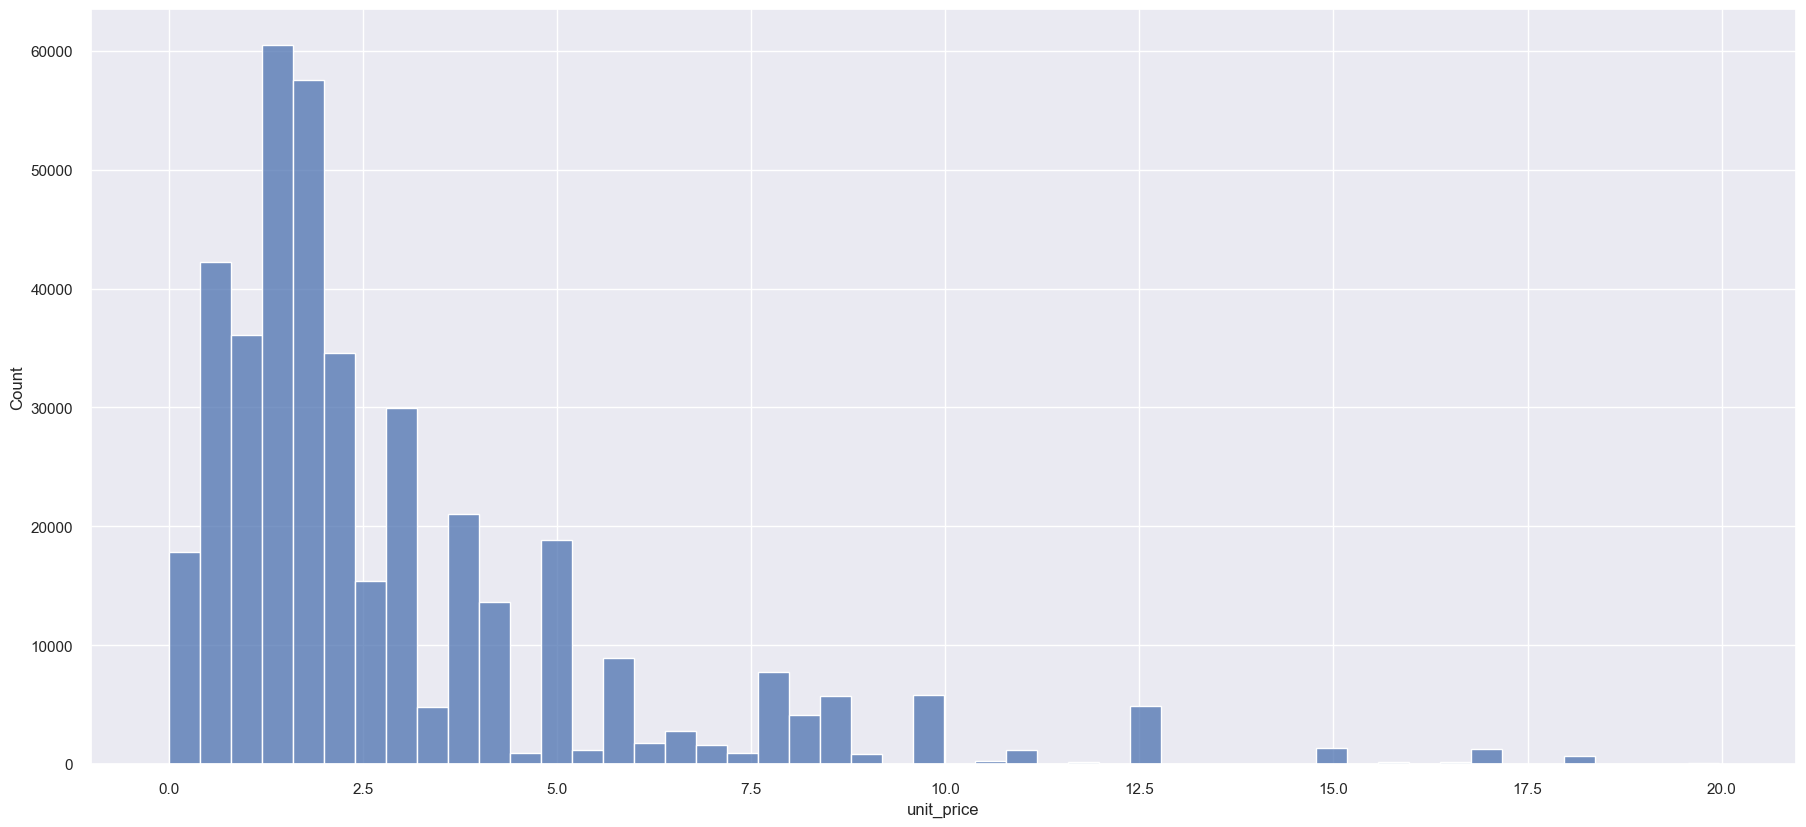

In [149]:
aux = df2[df2['unit_price'] < 20]
sns.histplot(x='unit_price', bins=50, data=aux);

In [150]:
# remove unit_price bellow 0.030 (bellow this consider promo or return)
df2 = df2[df2['unit_price'] > 0.030]

# remove stock code with only categoricals variables
df2 = df2[~df2['stock_code'].isin(['POST', 'D', 'M', 'PADS', 'DOT', 'CRUK'])]

# removes information from unidentified countries
df2 = df2[~df2['country'].isin(['European Community', 'Unspecified'])]

# separate dataframes for purchases and refunds
df2_purchases = df2[df2['quantity'] >= 0]
df2_returns = df2[df2['quantity'] < 0]

## 2.2 Seleção das colunas

In [151]:
df2.drop(columns='description', axis=1, inplace=True)

# 3.0 Feature Engineering

In [157]:
df3 = df2.copy()

## 3.1 MindMap Hypothesis

## 3.2 Lista final de hipóteses

## 3.3 Feature Engineering

In [158]:
# -------------------- Features based on RFM Model ---------------
# make data frame for reference
df_ref = df3[['customer_id']].drop_duplicates(ignore_index=True)


# Gross Revenue (Faturamento) | quantity * price
df2_purchases['gross_revenue'] = df2_purchases['quantity'] * df2_purchases['unit_price']


# Monetary - Total buys from each customer
df_monetary = df2_purchases[['customer_id', 'gross_revenue']].groupby('customer_id').sum().reset_index()
df_ref = pd.merge(df_ref, df_monetary, on='customer_id', how='left')


# Recency - Last day purchase for each customer
df_recency = df2_purchases[['customer_id', 'invoice_date']].groupby('customer_id').max().reset_index()
df_recency['recency_days'] = (df3['invoice_date'].max() - df_recency['invoice_date']).dt.days
df_recency.drop(columns=['invoice_date'], inplace=True)
df_ref = pd.merge(df_ref, df_recency, on='customer_id', how='left')


# Frequency - total number of purchases
df_freq = df2_purchases[['customer_id', 'invoice_no']].drop_duplicates().groupby('customer_id').count().reset_index()
df_ref = pd.merge(df_ref, df_freq, on='customer_id', how='left')

# Avg ticket - average purchases per customer
df_avg_ticket = df2_purchases[['customer_id', 'gross_revenue']].groupby('customer_id').mean().reset_index()
df_avg_ticket.columns = ['customer_id', 'avg_ticket']
df_ref = pd.merge(df_ref, df_avg_ticket, how='left', on='customer_id')

df_ref.isna().sum()

customer_id       0
gross_revenue    27
recency_days     27
invoice_no       27
avg_ticket       27
dtype: int64

In [159]:
df_ref = df_ref.dropna()
df_ref.isna().sum()

customer_id      0
gross_revenue    0
recency_days     0
invoice_no       0
avg_ticket       0
dtype: int64

# 4.0 Análise exploratória dos dados

## 4.1 Análise Univariada

In [160]:
df4 = df_ref.copy()

### 4.1.1 Response Variable

### 4.1.2 Numerical Variable

### 4.1.3 Categorical Variable

## 4.2 Análise Bivariada

### H1. Lojas com maior sortimento deveriam vender mais na media.

**VERDADEIRA** Lojas com MAIOR SORTIMENTO vendem em média MAIS

### 4.2.1 Resumo das Hipóteses

## 4.3 Análise Multivariada

### 4.3.1 Atributos numéricos

### 4.3.2 Atributos categóricos

# 5.0 Preparação dos dados

In [175]:
df5 = df4.copy()

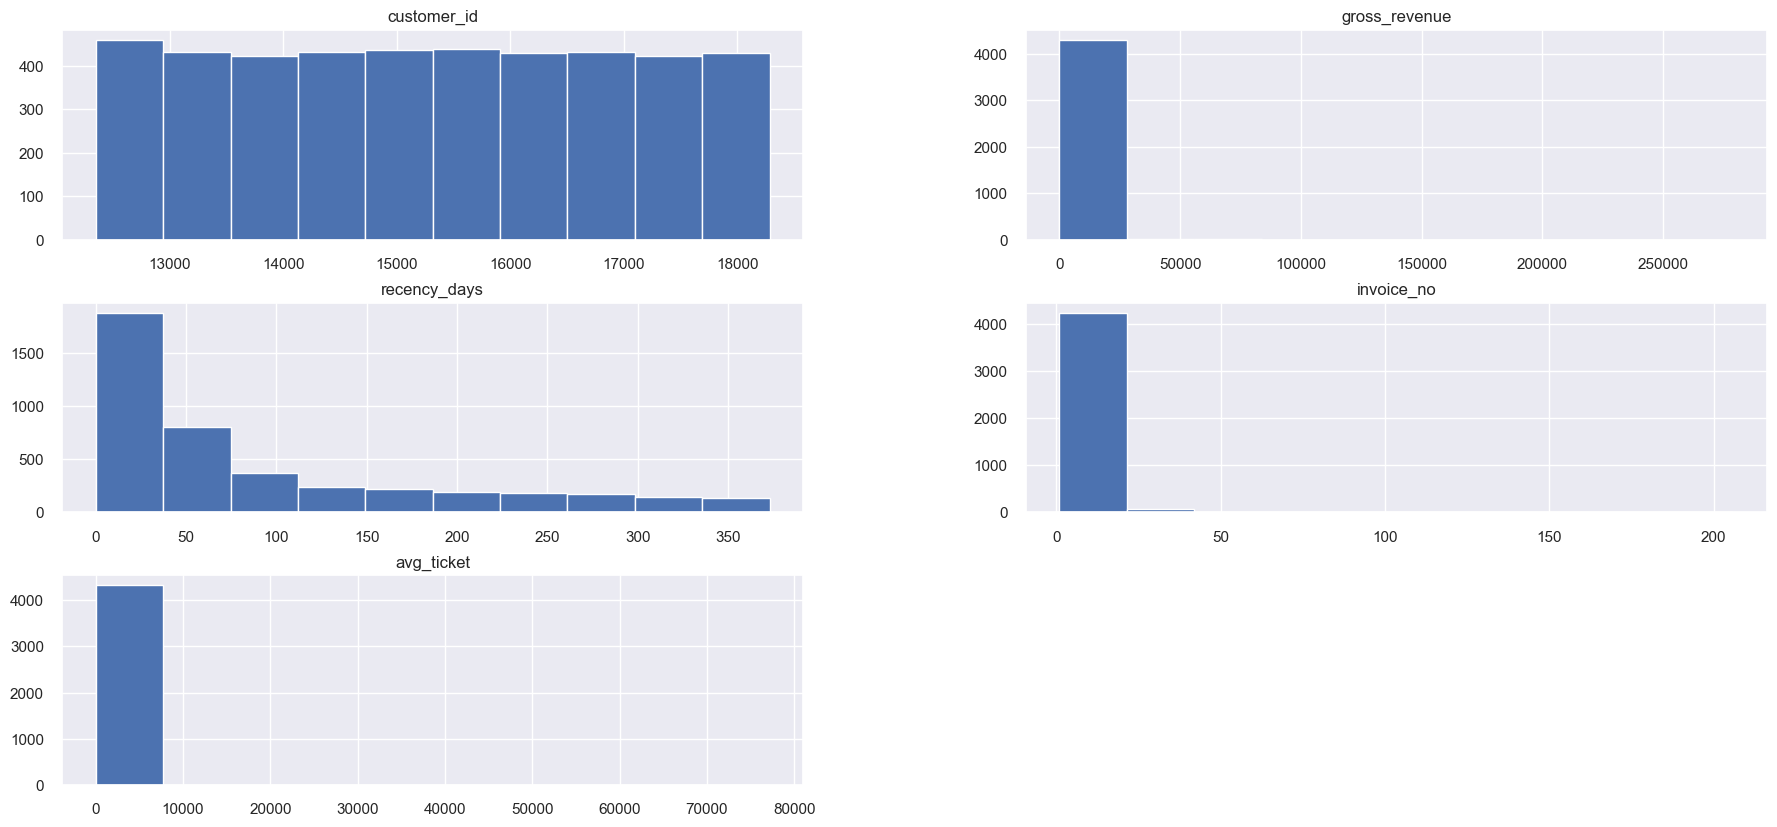

In [164]:
df5.hist();

## 5.1 Normalização

## 5.2 Rescaling

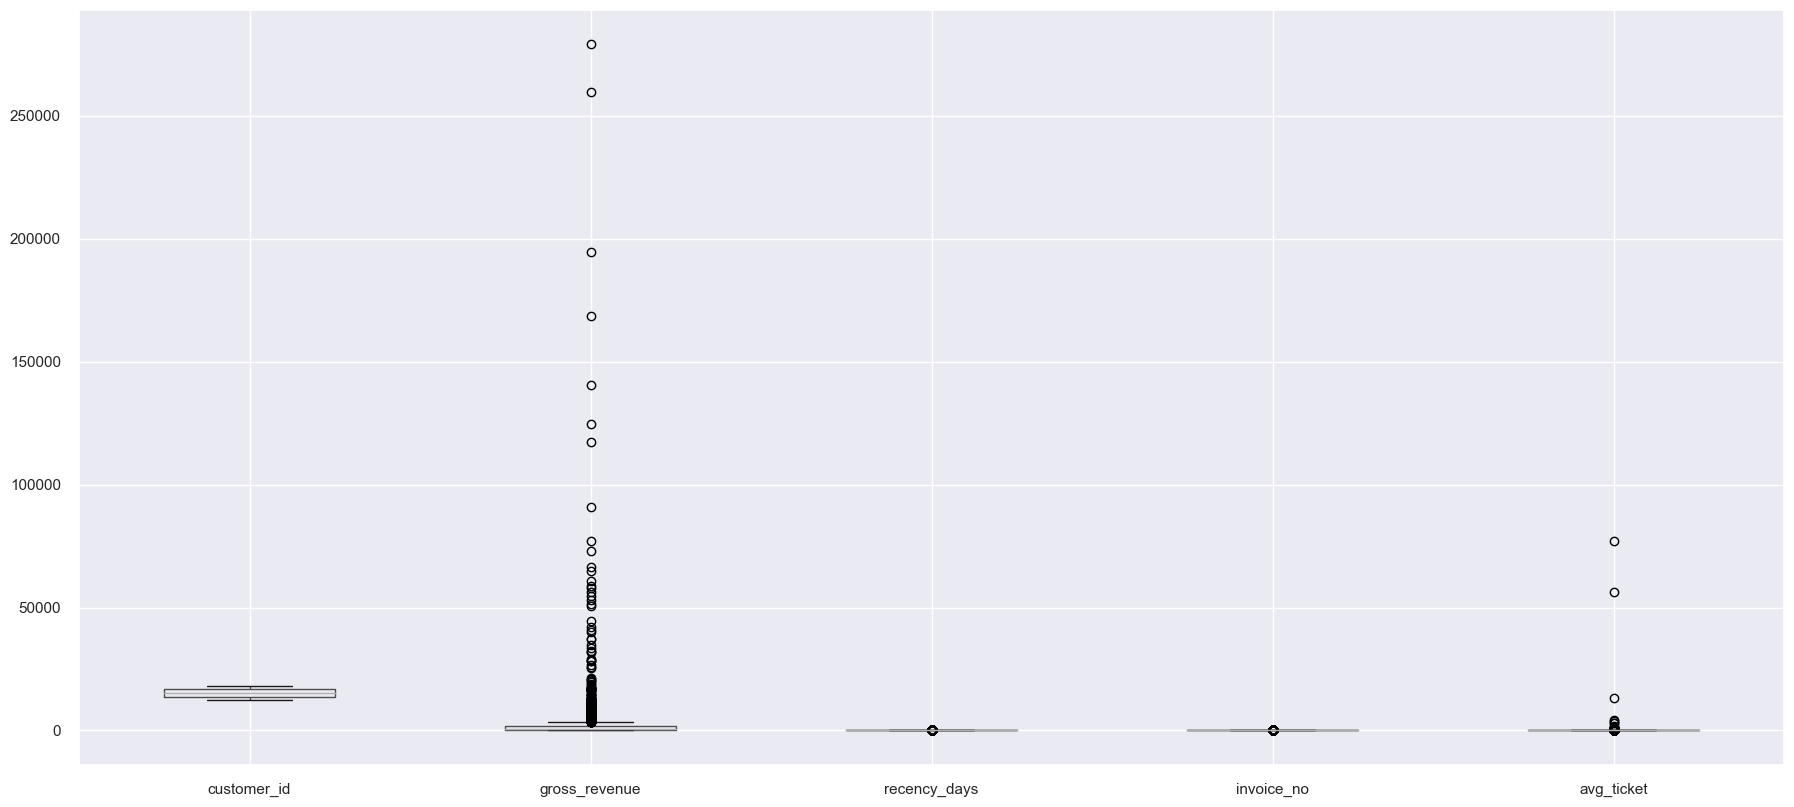

In [168]:
df5.boxplot();

In [170]:
df5.head()

,customer_id,gross_revenue,recency_days,invoice_no,avg_ticket
0,17850,5391.210,372.000,34.000,18.152
1,13047,3232.590,56.000,9.000,18.904
2,12583,6705.380,2.000,15.000,28.902
3,13748,948.250,95.000,5.000,33.866
4,15100,876.000,333.000,3.000,292.000


In [176]:
rs = pp.RobustScaler()

df5['gross_revenue'] = rs.fit_transform(df5[['gross_revenue']].values)
df5['recency_days'] = rs.fit_transform(df5[['recency_days']].values)
df5['invoice_no'] = rs.fit_transform(df5[['invoice_no']].values)
df5['avg_ticket'] = rs.fit_transform(df5[['avg_ticket']].values)

## 5.3 Transformação

### 5.3.1 Encoding

### 5.3.3 Nature Transformation

# 6.0 Feature Selection

In [186]:
df6 = df5.copy()

## 6.1 Split Dataframe into training and test dataset

## 6.2 Boruta as feature selector

## 6.3 Manual Feature Selection

# 7.0 Hyper Parameter Fine Tunning

In [187]:
# drop customer id for ML train
X = df6.drop(columns=['customer_id'])
X

,gross_revenue,recency_days,invoice_no,avg_ticket
0,3.558,2.576,8.000,0.048
1,1.932,0.048,1.750,0.108
2,4.547,-0.384,3.250,0.917
3,0.211,0.360,0.750,1.318
4,0.157,2.264,0.250,22.185
...,...,...,...,...
4352,-0.355,-0.392,-0.250,-0.093
4353,-0.245,-0.392,-0.250,0.123
4354,-0.232,-0.392,-0.250,13.131
4355,-0.332,-0.392,-0.250,0.112


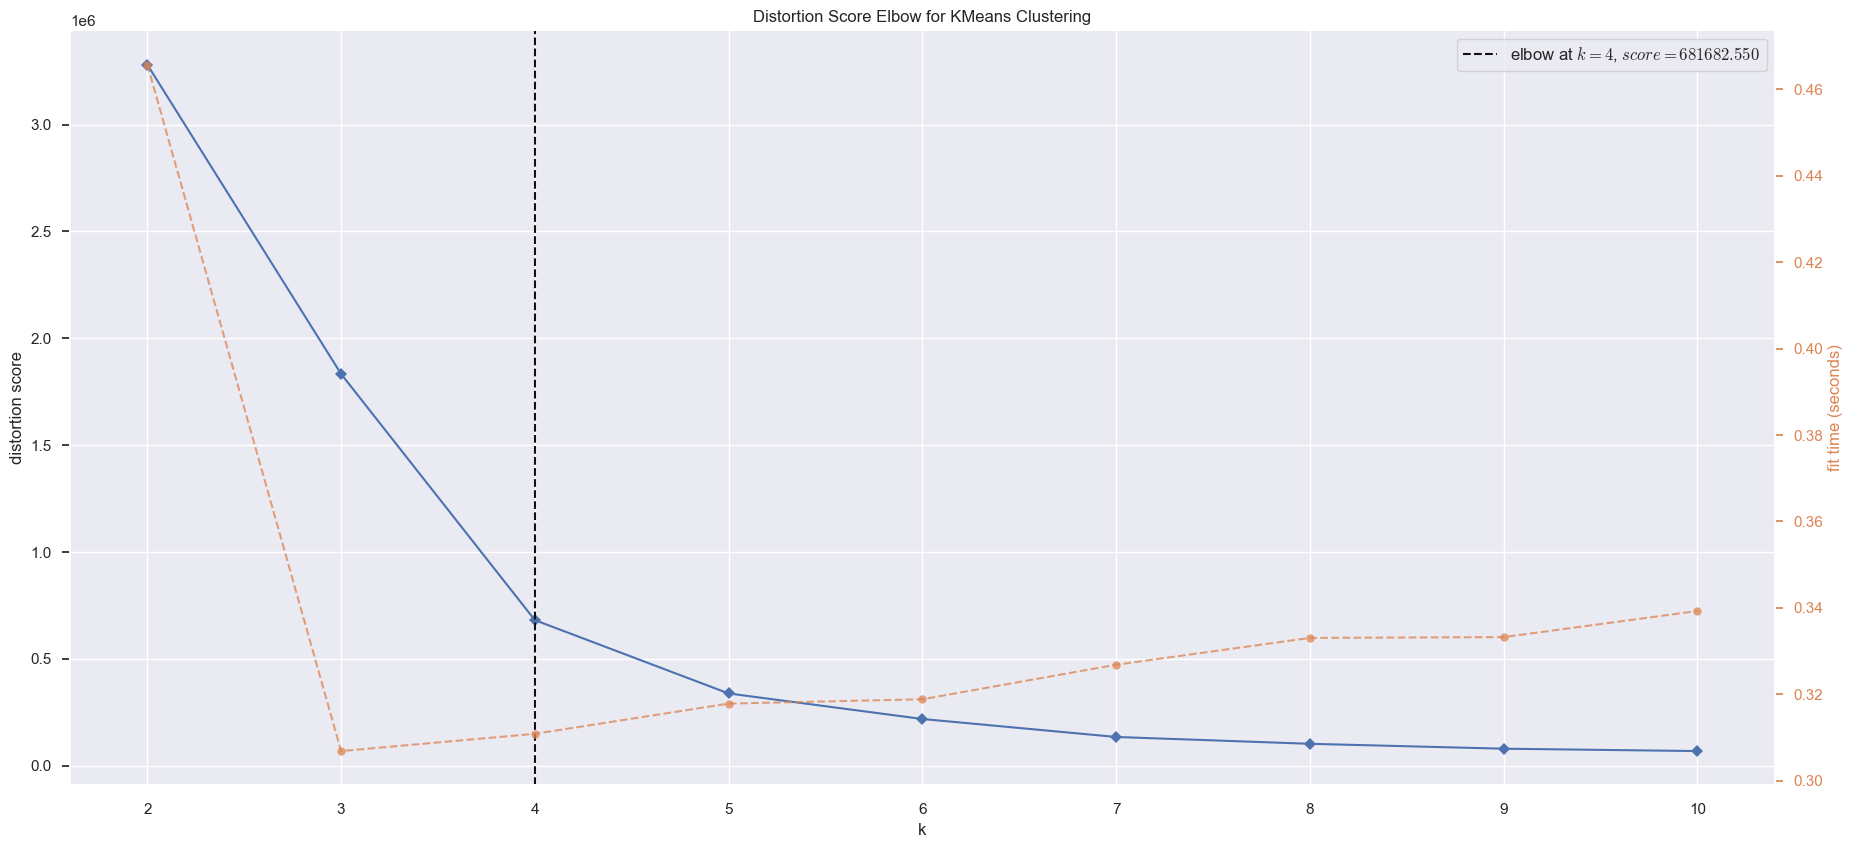

In [188]:
# make search space for clusters
clusters = [2, 3, 4, 5, 6, 7, 8, 9, 10]

# Analysis metric - WSS (Within-Cluster Sum of Squares)
kmeans = KElbowVisualizer(c.KMeans(), k=clusters, timings=True)
kmeans.fit(X)
kmeans.show();

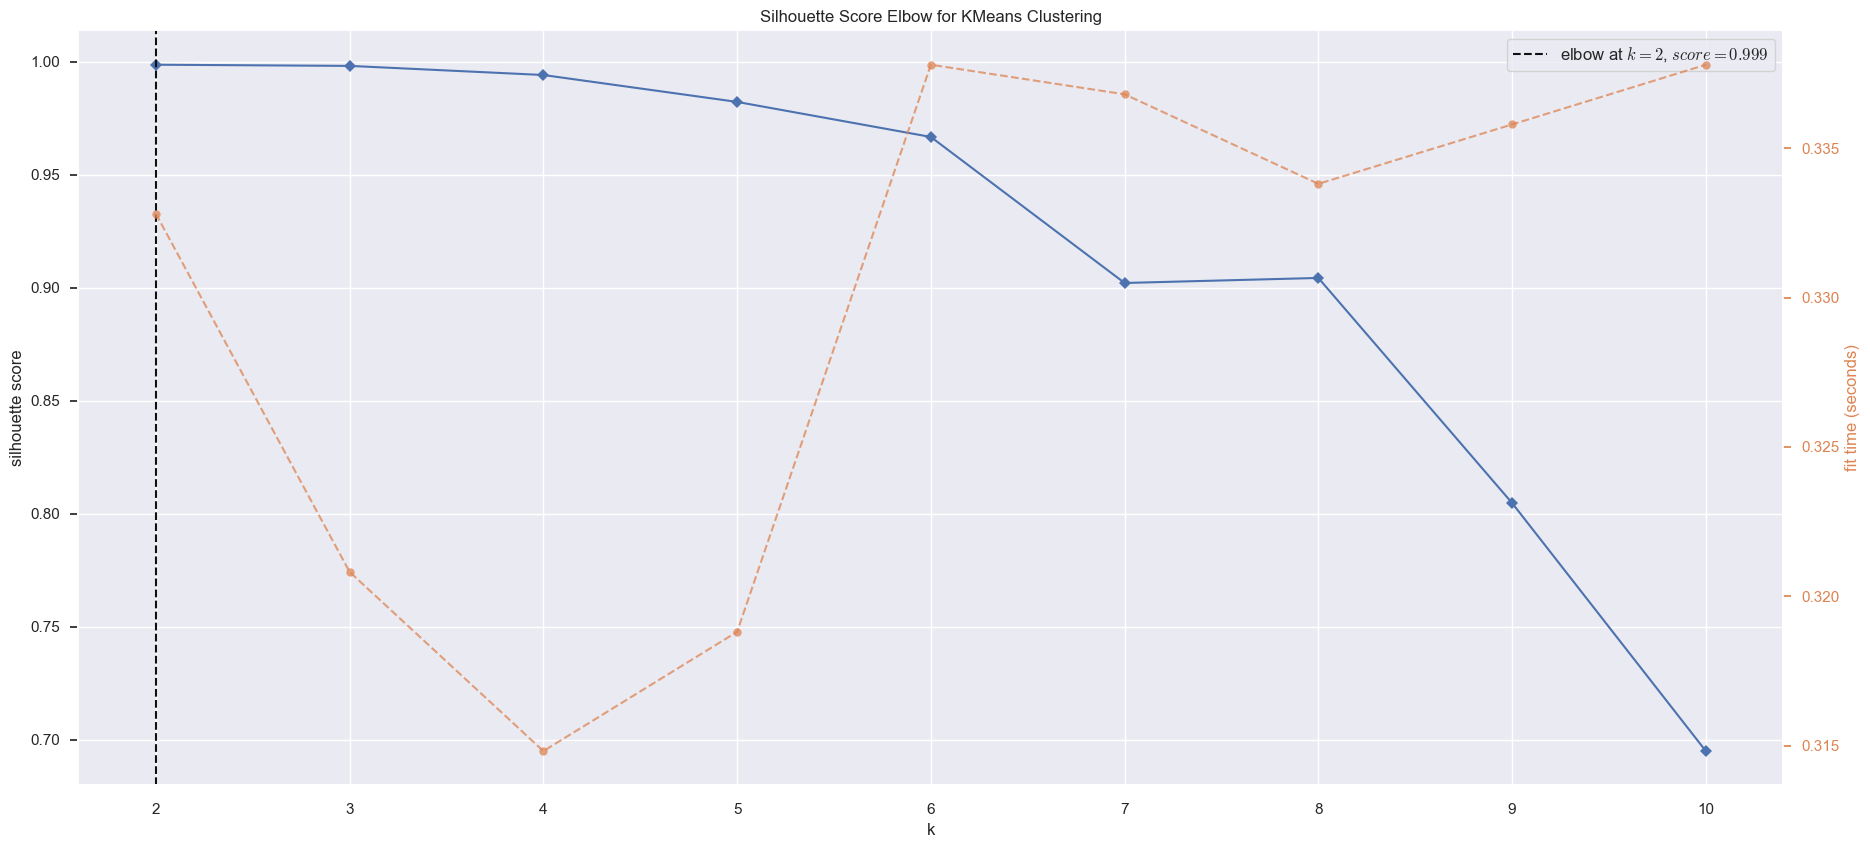

In [189]:
# Analysis metric - SS (Silhouette score)
kmeans = KElbowVisualizer(c.KMeans(), k=clusters, metric='silhouette', timings=True)
kmeans.fit(X)
kmeans.show();

## 7.1 Silhouette Analysis

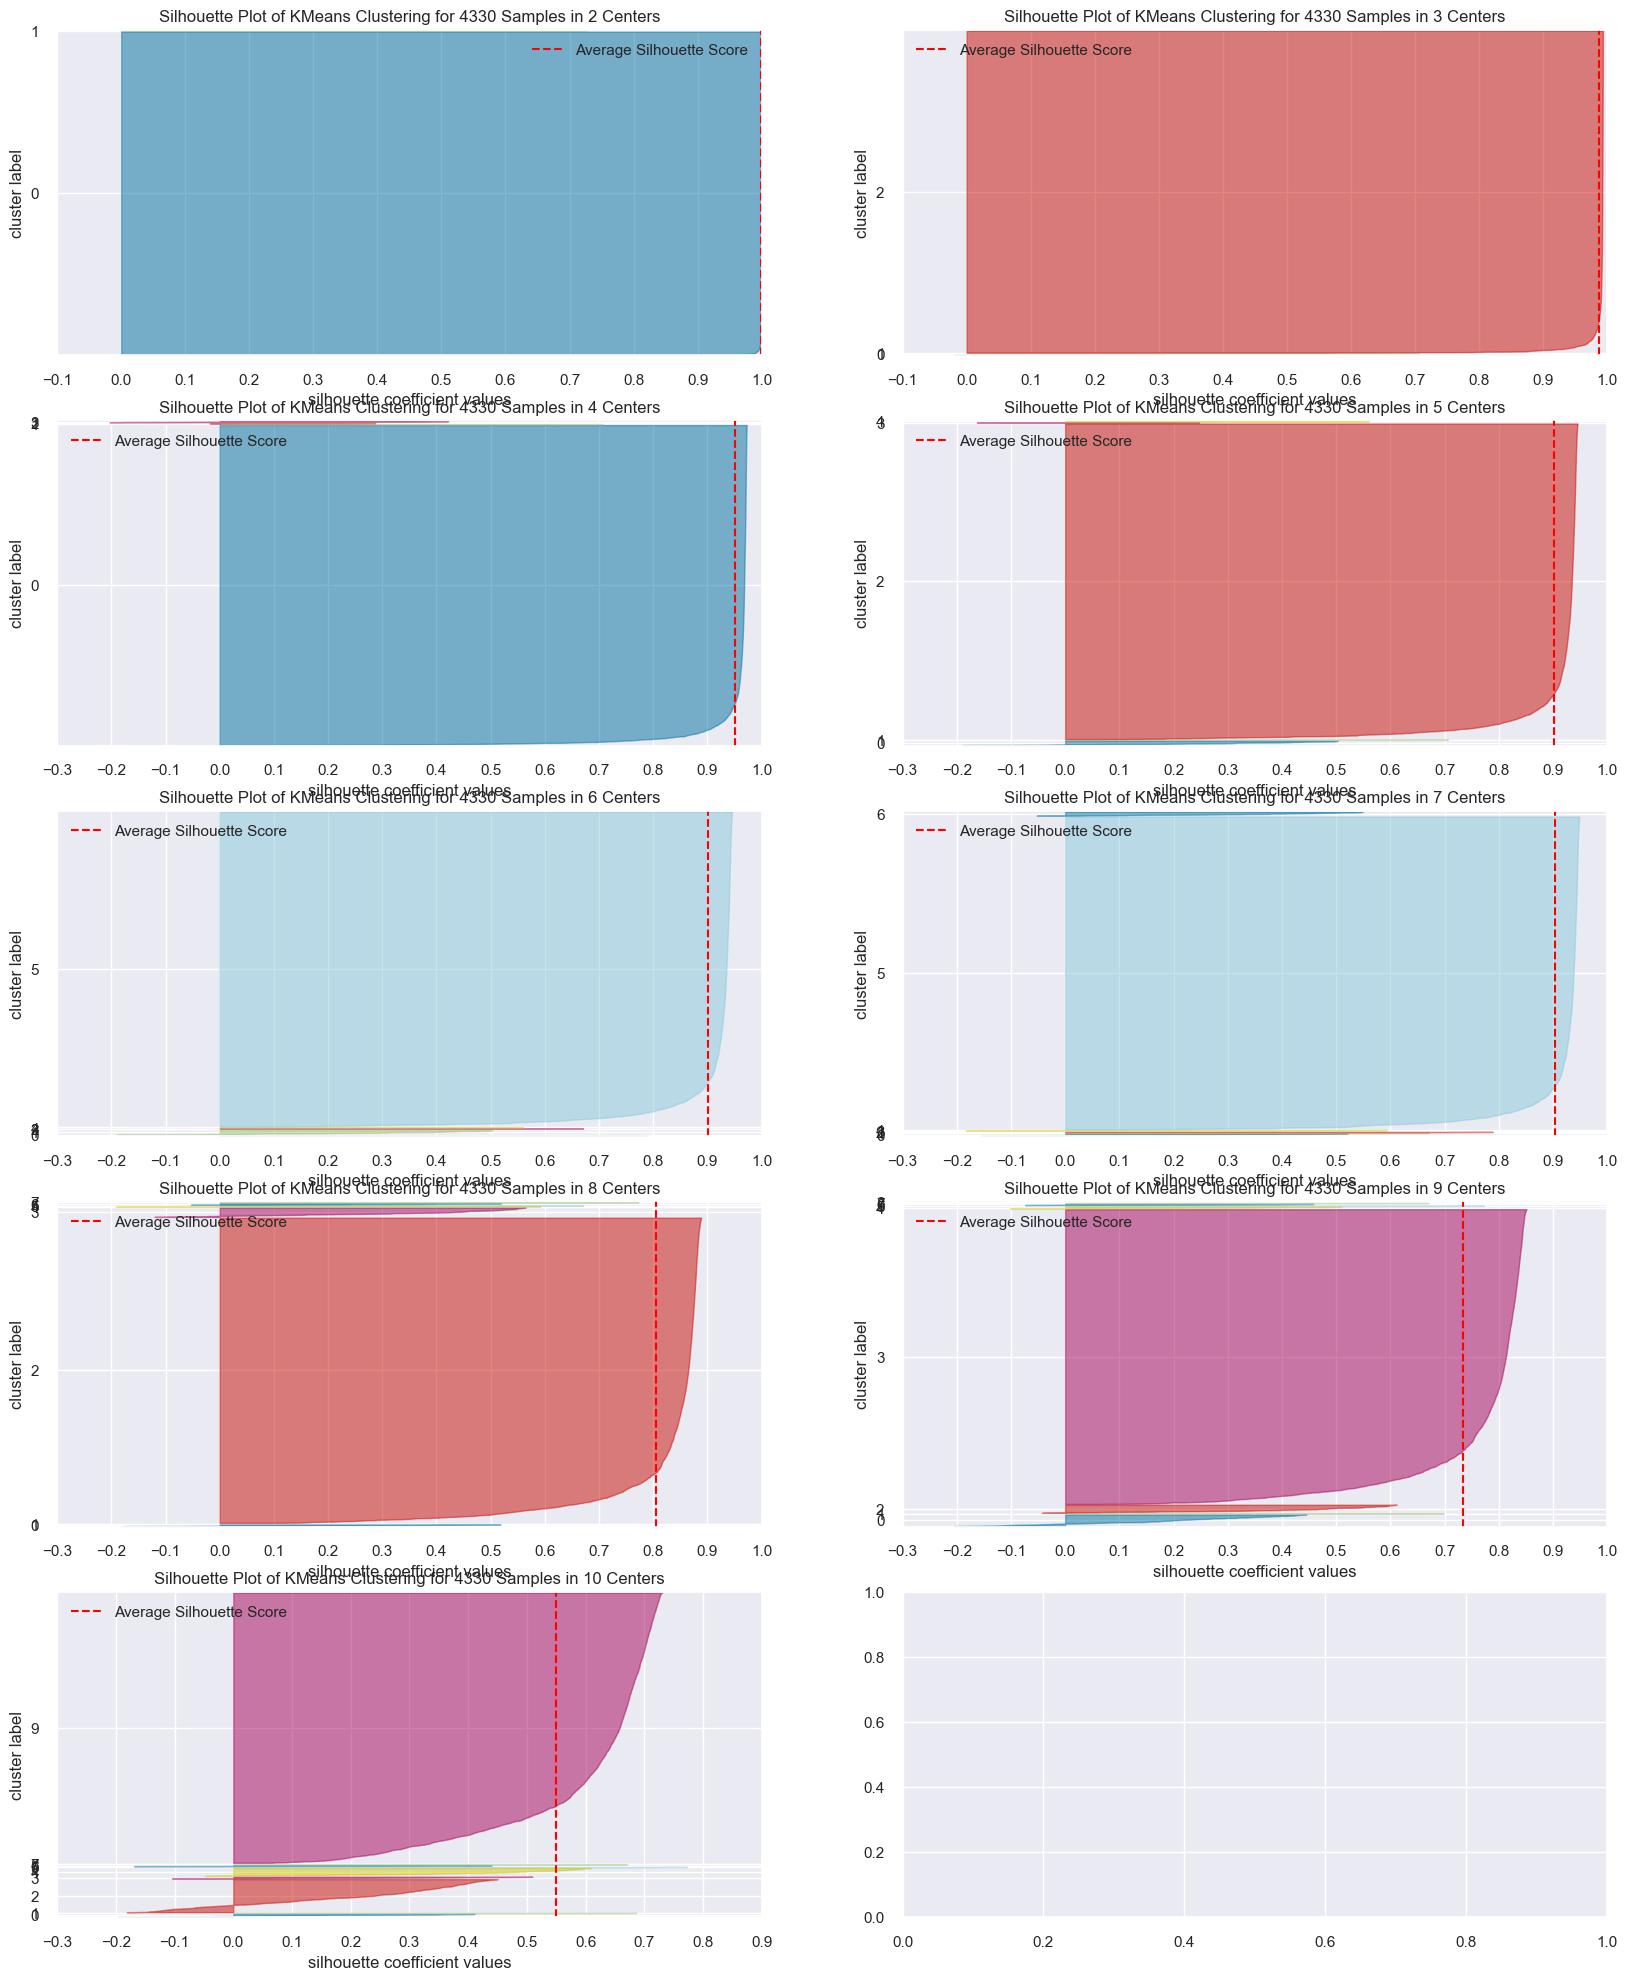

In [190]:
fig, ax = plt.subplots(5, 2, figsize=(20,25))

for k in clusters:
    km = c.KMeans(n_clusters=k, init='random', n_init=10, max_iter=100, random_state=42)
    q, mod = divmod(k, 2)

    visualizer = SilhouetteVisualizer(km, colors='yellowbrick', ax=ax[q-1][mod])
    visualizer.fit(X)
    visualizer.finalize();

# 8.0 Machine Learning Modeling

## 8.1 K-Means

In [193]:
# model definition
k = 4
kmeans = c.KMeans(init='random', n_clusters=k, n_init=10, max_iter=300)

# model training
kmeans.fit(X)

# clustering
labels = kmeans.labels_

## 8.2 Cluster Validation

In [194]:
# WSS (Within_cluster sum of square)
print(f'WSS Value: {kmeans.inertia_}')

# SS (Silhouette Score)
SS = m.silhouette_score(X, labels)
print(f'SS Value: {SS}')

WSS Value: 2158451.711461645
SS Value: 0.9507846680353408


## 8.6 Compare Model's Performance

### 8.6.2 Real Performance - Cross Validation

# 9.0 Cluster Analysis

In [200]:
df9 = df4.copy()
df9['cluster'] = labels
df9.head()

,customer_id,gross_revenue,recency_days,invoice_no,avg_ticket,cluster
0,17850,5391.210,372.000,34.000,18.152,0
1,13047,3232.590,56.000,9.000,18.904,0
2,12583,6705.380,2.000,15.000,28.902,0
3,13748,948.250,95.000,5.000,33.866,0
4,15100,876.000,333.000,3.000,292.000,0


## 9.1 Visualization Inspection

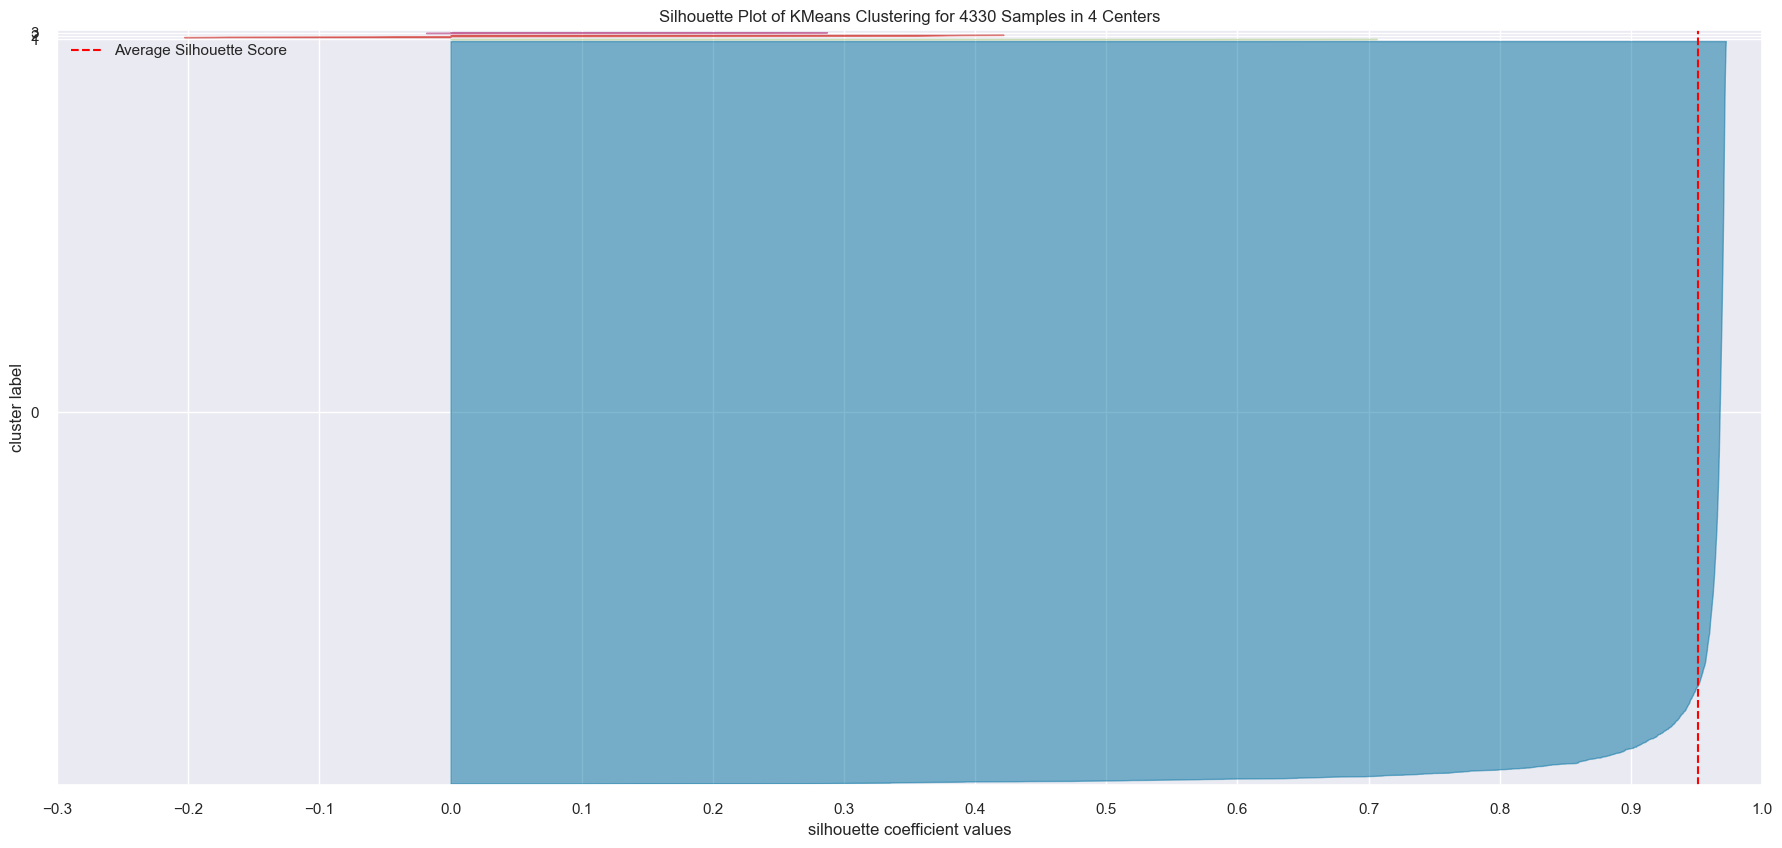

In [201]:
visualizer = SilhouetteVisualizer(kmeans, colors='yellowbrick')
visualizer.fit(X)
visualizer.finalize();

## 9.2 2D Plot

In [202]:
df_vis = df9.drop(columns='customer_id', axis=1)
#sns.pairplot(df_vis, hue='cluster');

## 9.3 UMAP

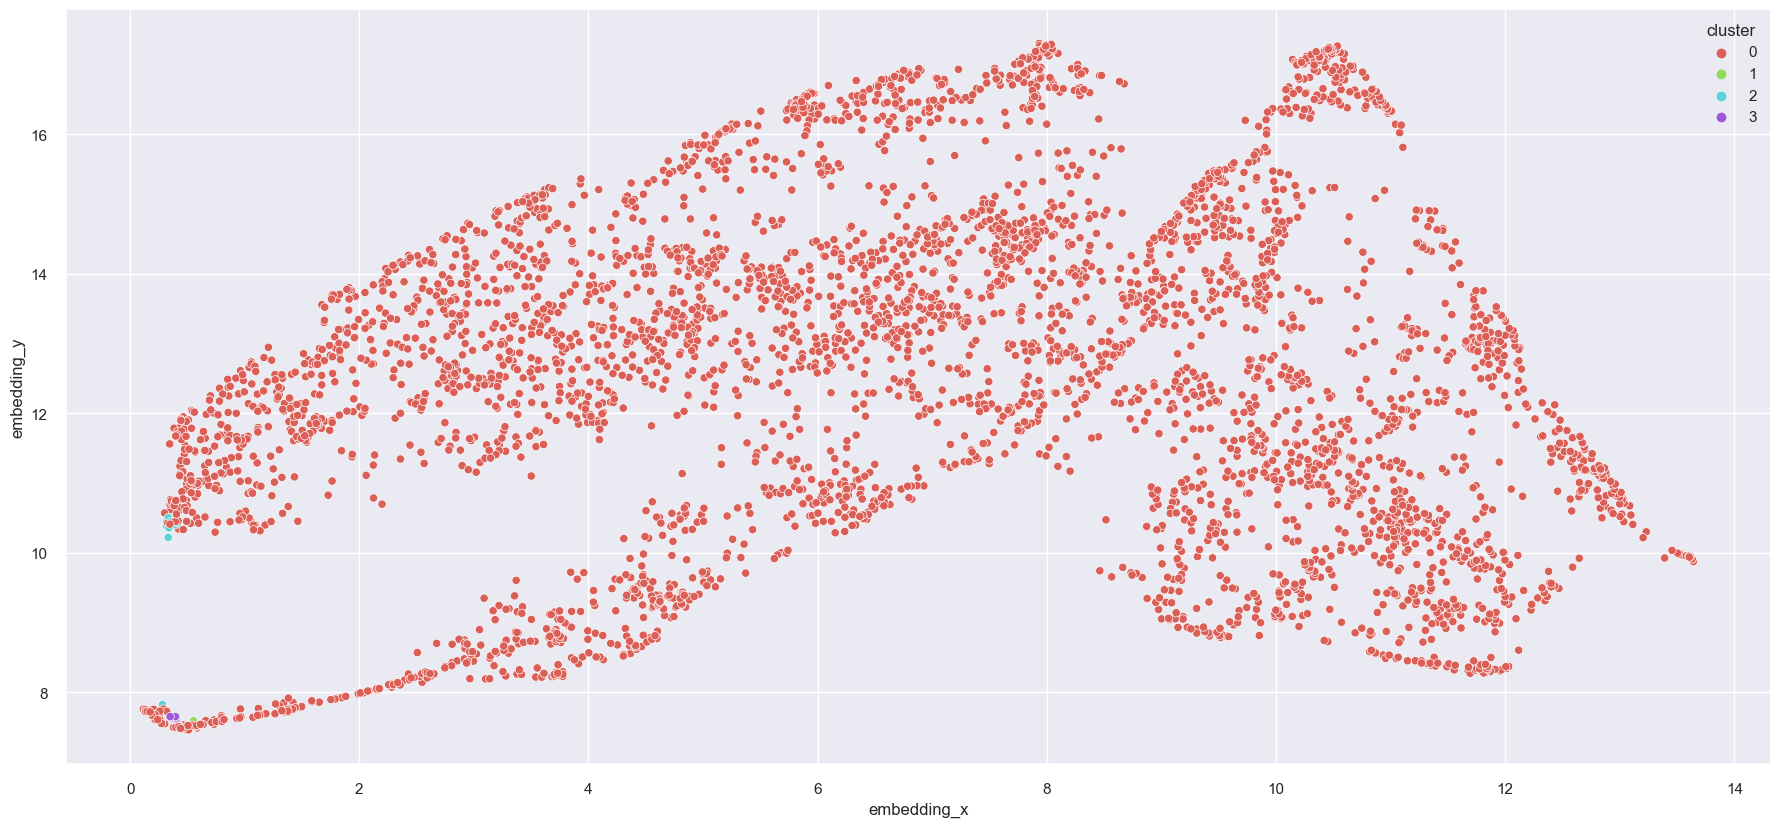

In [203]:
reducer = umap.UMAP(n_neighbors=80, random_state=42)
embedding = reducer.fit_transform(X)

# Embedding
df_vis['embedding_x'] = embedding[:,0]
df_vis['embedding_y'] = embedding[:,1]

# Plot UMAP
sns.scatterplot(x='embedding_x', y='embedding_y', hue='cluster', palette=sns.color_palette('hls', n_colors=len(df_vis['cluster'].unique())), data=df_vis);

## 9.4 Cluster Profile

In [204]:
# Number of customers
df_cluster = df9[['customer_id', 'cluster']].groupby('cluster').count().reset_index()
df_cluster['perc_customer'] = 100 * (df_cluster['customer_id'] / df_cluster['customer_id'].sum())

# Avg Gross revenue
df_avg_gross_revenue = df9[['gross_revenue', 'cluster']].groupby('cluster').mean().reset_index()
df_cluster = pd.merge(df_cluster, df_avg_gross_revenue, how='inner', on='cluster')

# Avg recency days
df_avg_recency_days = df9[['recency_days', 'cluster']].groupby('cluster').mean().reset_index()
df_cluster = pd.merge(df_cluster, df_avg_recency_days, how='inner', on='cluster')

# Avg invoice_no
df_invoice_no = df9[['invoice_no', 'cluster']].groupby('cluster').mean().reset_index()
df_cluster = pd.merge(df_cluster, df_invoice_no, how='inner', on='cluster')

# Avg Ticket
df_ticket = df9[['avg_ticket', 'cluster']].groupby('cluster').mean().reset_index()
df_cluster = pd.merge(df_cluster, df_ticket, how='inner', on='cluster')

df_cluster

,cluster,customer_id,perc_customer,gross_revenue,recency_days,invoice_no,avg_ticket
0,0,4309,99.515,1573.119,92.326,4.064,30.065
1,1,2,0.046,122828.050,162.500,1.500,66670.550
2,2,14,0.323,117518.255,7.143,62.929,263.022
3,3,5,0.115,18922.144,181.000,1.800,5583.770


**Cluster 0:**

- Número de customer: 4.309 (99,51% dos customers)
- Recência em média: 92 dias
- Compras em média: 4 compras
- Receita em média: € 1.573,12
- Ticket médio: € 30,06

**Cluster 1:**

- Número de customer: 2 (0,04% dos customers)
- Recência em média: 162 dias
- Compras em média: 1 compras
- Receita em média: € 122.828,05
- Ticket médio: € 66.670,55

**Cluster 2: (Candidato a Insider)**

- Número de customer: 14 (0,32% dos customers)
- Recência em média: 7 dias
- Compras em média: 63 compras
- Receita em média: € 117.518,25
- Ticket médio: € 263,02

**Cluster 3:**

- Número de customer: 5 (0,11% dos customers)
- Recência em média: 181 dias
- Compras em média: 2 compras
- Receita em média: € 18.922,14
- Ticket médio: € 5.583,77

# 10.0 Deploy model to production